In [11]:
# Pre-train용
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        labels=None,
        output_hidden_states=True
    ):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            labels=labels,
            output_hidden_states=output_hidden_states
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states[-8]  # n번째 레이어의 hidden states를 반환합니다.
        loss = outputs.loss
        return logits, loss, hidden_states

# 데이터 로드 및 전처리
data_A = pd.read_csv("output1.csv")  # data set A 파일명에 맞게 수정
data_B = pd.read_csv("infected.csv")  # data set B 파일명에 맞게 수정
# 모델 저장 경로
model_path = "Pre-trained.pt"

# X_train, Y_train 생성
X_train = []
Y_train = []

for index, row in data_A.iterrows():  # 중복 제거를 하지 않고 원본 데이터 사용
    patient_id = row["ID"]
    patient_info = [str(row[column]) for column in data_A.columns if column != "ID" and column != "DESCRIPTION"]
    symptoms = ", ".join(data_A[data_A["ID"] == patient_id]["DESCRIPTION"].tolist())
    combined_info = ", ".join(patient_info) + ", " + symptoms
    X_train.append(combined_info)
    if patient_id in data_B.values:
        Y_train.append(1)
    else:
        Y_train.append(0)

print("X_train\n", X_train[:10])
print("Y_train\n", Y_train[:10])
        
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# 입력 데이터를 BERT의 입력 형식으로 변환
max_len = 128  # 입력 시퀀스의 최대 길이

input_ids = []
attention_masks = []

for info in X_train:
    encoded_dict = tokenizer.encode_plus(
                        info,                         # 환자 정보 및 증상
                        add_special_tokens = True,    # [CLS], [SEP] 토큰 추가
                        max_length = max_len,         # 최대 길이 지정
                        pad_to_max_length = True,     # 패딩을 추가하여 최대 길이로 맞춤
                        return_attention_mask = True, # 어텐션 마스크 생성
                        return_tensors = 'pt',        # PyTorch 텐서로 반환
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Y_train)

# 데이터셋 및 데이터로더 생성
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = 0.8
train_dataset, val_dataset = train_test_split(dataset, test_size=1-train_size, random_state=42)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 모델을 GPU로 이동
model.to(device)

# 옵티마이저 및 학습률 설정
# 기본 학습률 : 2e-6
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# 에폭 설정
epochs = 10

# 학습 루프
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs[1]  # loss가 outputs의 두 번째 값입니다.
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}')

    # 모델 저장 및 평가
    model_save_path = f"Pre_train_epoch{epoch + 1}_BERT_Based.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved for epoch {epoch + 1} at {model_save_path}")
    
    model.eval()
    val_accuracy = 0
    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs[0]  # logits가 outputs의 첫 번째 값입니다.
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        val_accuracy += (logits.argmax(axis=1) == label_ids).mean().item()

    print(f'Validation Accuracy for epoch {epoch + 1}: {val_accuracy / len(val_dataloader)}')


X_train
 ['7/29/1966, nan, 999-91-3709, S99988287, X5601074X, Mrs., Celia938, Roberts511, nan, Mayert710, M, white, hispanic, F, Agawam  Massachusetts  US, 362 Pacocha Gateway Apt 1, Northborough, Massachusetts, Worcester County, 1532.0, 42.27341123, -71.63243239, 1166971.45, 13416.2, 4/20/1989, nan, 5cfda74f-b462-4c73-aa96-d90da4002f8a, 40055000.0, Chronic sinusitis (disorder), Body mass index 30+ - obesity (finding), Miscarriage in first trimester, Prediabetes, Hyperlipidemia, Nasal congestion (finding), Cough (finding), Sore throat symptom (finding), Sputum finding (finding), Muscle pain (finding), Joint pain (finding), Fever (finding)', '12/19/1965, 3/1/2020, 999-70-4989, S99948277, X2560575X, Mrs., Kala987, Prohaska837, nan, Gleason633, M, white, nonhispanic, F, Boston  Massachusetts  US, 310 Effertz Promenade, Gloucester, Massachusetts, Essex County, 1930.0, 42.63072986, -70.6443488, 1229943.52, 20003.74, 2/12/1984, nan, 3fc7077f-903c-4601-8078-a016e9b5a630, 59621000.0, Hypertens

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\MCC\anaconda3\envs\biotf\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to 

True
Epoch 1/10, Average Training Loss: 0.3671693565595038
Model saved for epoch 1 at Pre_train_epoch1.pt
Validation Accuracy for epoch 1: 0.884929906542056
Epoch 2/10, Average Training Loss: 0.320084329764468
Model saved for epoch 2 at Pre_train_epoch2.pt
Validation Accuracy for epoch 2: 0.883427903871829
Epoch 3/10, Average Training Loss: 0.31441075814791686
Model saved for epoch 3 at Pre_train_epoch3.pt
Validation Accuracy for epoch 3: 0.8841789052069426
Epoch 4/10, Average Training Loss: 0.3108887806219954
Model saved for epoch 4 at Pre_train_epoch4.pt
Validation Accuracy for epoch 4: 0.8841789052069426
Epoch 5/10, Average Training Loss: 0.3103741247539229
Model saved for epoch 5 at Pre_train_epoch5.pt
Validation Accuracy for epoch 5: 0.884929906542056
Epoch 6/10, Average Training Loss: 0.30494501469700547
Model saved for epoch 6 at Pre_train_epoch6.pt
Validation Accuracy for epoch 6: 0.883427903871829
Epoch 7/10, Average Training Loss: 0.2898066947018037
Model saved for epoch 7 at

In [60]:
import torch
import torch.nn as nn

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_parameter_sizes(model):
    for name, param in model.named_parameters():
        print(f"Layer: {name}, Size: {param.numel()}")


model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
print("Total number of parameters:", count_parameters(model))
print_parameter_sizes(model)

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total number of parameters: 109483778
Layer: bert.embeddings.word_embeddings.weight, Size: 23440896
Layer: bert.embeddings.position_embeddings.weight, Size: 393216
Layer: bert.embeddings.token_type_embeddings.weight, Size: 1536
Layer: bert.embeddings.LayerNorm.weight, Size: 768
Layer: bert.embeddings.LayerNorm.bias, Size: 768
Layer: bert.encoder.layer.0.attention.self.query.weight, Size: 589824
Layer: bert.encoder.layer.0.attention.self.query.bias, Size: 768
Layer: bert.encoder.layer.0.attention.self.key.weight, Size: 589824
Layer: bert.encoder.layer.0.attention.self.key.bias, Size: 768
Layer: bert.encoder.layer.0.attention.self.value.weight, Size: 589824
Layer: bert.encoder.layer.0.attention.self.value.bias, Size: 768
Layer: bert.encoder.layer.0.attention.output.dense.weight, Size: 589824
Layer: bert.encoder.layer.0.attention.output.dense.bias, Size: 768
Layer: bert.encoder.layer.0.attention.output.LayerNorm.weight, Size: 768
Layer: bert.encoder.layer.0.attention.output.LayerNorm.bias

In [23]:
# Fine-tune용
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        labels=None,
        output_hidden_states=True
    ):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            labels=labels,
            output_hidden_states=output_hidden_states
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states[-8]  # n번째 레이어의 hidden states를 반환합니다.
        loss = outputs.loss
        return logits, loss, hidden_states

# 데이터 로드 및 전처리
data_A = pd.read_csv("output3.csv")  # data set A 파일명에 맞게 수정
data_B = pd.read_csv("infected.csv")  # data set B 파일명에 맞게 수정
# 모델 불러오는 경로
model_path = "Pre_train_epoch10.pt"
# 모델 저장경로
model_path2 = "Fine-tuned.pt"

# X_train, Y_train 생성
X_train = []
Y_train = []

for index, row in data_A.iterrows():  # 중복 제거를 하지 않고 원본 데이터 사용
    patient_id = row["ID"]
    patient_info = [str(row[column]) for column in data_A.columns if column != "ID" and column != "DESCRIPTION"]
    symptoms = ", ".join(data_A[data_A["ID"] == patient_id]["DESCRIPTION"].tolist())
    combined_info = ", ".join(patient_info) + ", " + symptoms
    X_train.append(combined_info)
    if patient_id in data_B.values:
        Y_train.append(1)
    else:
        Y_train.append(0)

print("X_train\n", X_train[:10])
print("Y_train\n", Y_train[:10])
        
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# 모델이 이미 저장되어 있는지 확인하고, 저장된 모델이 있으면 불러오고 없으면 새로운 모델 생성
if os.path.exists(model_path):
    # 저장된 모델이 있을 경우 불러오기
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.load_state_dict(torch.load(model_path))
    print("Pre-train model loaded.")
else:
    # 저장된 모델이 없을 경우 새로운 모델 생성
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    print("New model generated.")

# 입력 데이터를 BERT의 입력 형식으로 변환
max_len = 128  # 입력 시퀀스의 최대 길이

input_ids = []
attention_masks = []

for info in X_train:
    encoded_dict = tokenizer.encode_plus(
                        info,                         # 환자 정보 및 증상
                        add_special_tokens = True,    # [CLS], [SEP] 토큰 추가
                        max_length = max_len,         # 최대 길이 지정
                        pad_to_max_length = True,     # 패딩을 추가하여 최대 길이로 맞춤
                        return_attention_mask = True, # 어텐션 마스크 생성
                        return_tensors = 'pt',        # PyTorch 텐서로 반환
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Y_train)

# 데이터셋 및 데이터로더 생성
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = 0.8
train_dataset, val_dataset = train_test_split(dataset, test_size=1-train_size, random_state=42)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 모델을 GPU로 이동
model.to(device)

# 옵티마이저 및 학습률 설정
# 기본 학습률 : 2e-6
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6)

# 에폭 설정
epochs = 20

# 학습 루프
hidden_states_list = []  # 모든 에폭에 대한 hidden state를 저장할 리스트
# 학습 루프
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs[1]  # loss가 outputs의 두 번째 값입니다.
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}')

    # 모델 저장 및 평가
    model_save_path = f"Fine_tuned_epoch{epoch + 1}_BERT_Based.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved for epoch {epoch + 1} at {model_save_path}")
    
    model.eval()
    val_accuracy = 0
    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs[0]  # logits가 outputs의 첫 번째 값입니다.
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        val_accuracy += (logits.argmax(axis=1) == label_ids).mean().item()

    print(f'Validation Accuracy for epoch {epoch + 1}: {val_accuracy / len(val_dataloader)}')


X_train
 ['11/6/2011, nan, 999-81-9641, nan, nan, nan, Mack300, Halvorson124, nan, nan, nan, asian, nonhispanic, M, Avon  Massachusetts  US, 617 Hane Corner Unit 24, New Bedford, Massachusetts, Bristol County, 2743.0, 41.5103414, -70.9350167, 26475.3, 2679.84, 12/29/2019, 1/12/2020, 566f4d11-728e-49c2-8954-d17fedd7037b, 444814009.0, Viral sinusitis (disorder), Nasal congestion (finding), Cough (finding), Fever (finding), Loss of taste (finding)', '3/3/2000, nan, 999-39-4367, S99951818, X24980388X, Ms., Renee555, Blanda868, nan, nan, nan, white, nonhispanic, F, Natick  Massachusetts  US, 176 Dicki Highlands, Salisbury, Massachusetts, Essex County, nan, 42.80175139, -70.84150456, 538129.79, 2975.64, 4/27/2018, nan, c6f413a4-eb4a-4d1f-ad1a-61585fad9b2e, 59621000.0, Hypertension, Sputum finding (finding), Fever (finding), Normal pregnancy', '7/27/1951, 8/16/2018, 999-92-8207, S99933636, X43360252X, Mrs., Kristin64, Mann644, JD, Price929, M, white, nonhispanic, F, Worcester  Massachusetts  

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Pre-train model loaded.
True
Epoch 1/20, Average Training Loss: 0.3677359550464444
Model saved for epoch 1 at Fine_tuned_epoch1_BERT_Based.pt
Validation Accuracy for epoch 1: 0.8814964157706093
Epoch 2/20, Average Training Loss: 0.3173808402767995
Model saved for epoch 2 at Fine_tuned_epoch2_BERT_Based.pt
Validation Accuracy for epoch 2: 0.8911290322580645
Epoch 3/20, Average Training Loss: 0.3079563873873009
Model saved for epoch 3 at Fine_tuned_epoch3_BERT_Based.pt
Validation Accuracy for epoch 3: 0.8911290322580645
Epoch 4/20, Average Training Loss: 0.30472496527481857
Model saved for epoch 4 at Fine_tuned_epoch4_BERT_Based.pt
Validation Accuracy for epoch 4: 0.8879928315412187
Epoch 5/20, Average Training Loss: 0.296230930017262
Model saved for epoch 5 at Fine_tuned_epoch5_BERT_Based.pt
Validation Accuracy for epoch 5: 0.8879928315412187
Epoch 6/20, Average Training Loss: 0.29320921779163484
Model saved for epoch 6 at Fine_tuned_epoch6_BERT_Based.pt
Validation Accuracy for epoch 6:

In [ ]:
# 데이터 랜덤분할(500/500/250)
import pandas as pd
import numpy as np

def sample_csv_and_additional(input_file, output_file_500, output_file_100, n_500):
    # CSV 파일을 읽어옵니다.
    data = pd.read_csv(input_file)
    
    # 데이터를 랜덤하게 샘플링합니다.
    sampled_data_750 = data.sample(n=n_500, random_state=42)
    
    # 첫 250개 데이터를 output_file_500과 output_file_100에 순서대로 삽입합니다.
    first_250 = sampled_data_750[:250]
    first_250.to_csv(output_file_500, index=False)
    first_250.to_csv(output_file_100, index=False)
    
    # 나머지 500개 데이터를 절반으로 나누어 각각 output_file_500과 output_file_100에 추가합니다.
    remaining_500 = sampled_data_750[250:]
    split_idx = len(remaining_500) // 2
    second_250_500 = remaining_500[:split_idx]
    second_250_100 = remaining_500[split_idx:]
    
    # 파일에 추가합니다.
    second_250_500.to_csv(output_file_500, mode='a', header=False, index=False)
    second_250_100.to_csv(output_file_100, mode='a', header=False, index=False)

# 입력 CSV 파일 경로
input_file = "output6.csv"

# 출력 CSV 파일 경로
output_file_500 = "random_500_D.csv"
output_file_100 = "random_500_C.csv"

# 랜덤하게 추출할 데이터 개수
n_500 = 750

# 함수 호출
sample_csv_and_additional(input_file, output_file_500, output_file_100, n_500)



In [14]:
# 데이터 랜덤분할(300/500)
import pandas as pd

def sample_csv_and_additional(input_file, output_file_500, output_file_100, n_500):
    # CSV 파일을 읽어옵니다.
    data = pd.read_csv(input_file)
    
    # 데이터를 랜덤하게 샘플링합니다.
    sampled_data_500 = data.sample(n=n_500, random_state=42)
    
    # 샘플링된 500개의 데이터를 CSV 파일로 내보냅니다.
    sampled_data_500.to_csv(output_file_500, index=False)
    
    # sampled_data_500에서 첫 100개의 데이터를 선택합니다.
    sampled_data_100 = sampled_data_500.head(500)
    
    # 선택된 첫 100개의 데이터를 CSV 파일로 내보냅니다.
    sampled_data_100.to_csv(output_file_100, index=False)

# 입력 CSV 파일 경로
input_file = "output6.csv"

# 출력 CSV 파일 경로
output_file_500 = "random_500.csv"
output_file_100 = "random_300.csv"

# 랜덤하게 추출할 데이터 개수
n_500 = 1000

# 함수 호출
sample_csv_and_additional(input_file, output_file_500, output_file_100, n_500)


In [4]:
# smashed data 생성 (500/server side)
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        labels=None,
        output_hidden_states=True
    ):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            labels=labels,
            output_hidden_states=output_hidden_states
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states[9]  # n번째 레이어의 hidden states를 반환합니다.
        loss = outputs.loss
        return logits, loss, hidden_states

# 데이터 로드 및 전처리
data_A = pd.read_csv("random_500.csv")  # data set A 파일명에 맞게 수정
data_B = pd.read_csv("infected.csv")  # data set B 파일명에 맞게 수정
# 모델 저장 경로
model_path = "Pre_train_epoch10.pt"

# X_train, Y_train 생성
X_train = []
Y_train = []

for index, row in data_A.iterrows():  # 중복 제거를 하지 않고 원본 데이터 사용
    patient_id = row["ID"]
    patient_info = [str(row[column]) for column in data_A.columns if column != "ID" and column != "DESCRIPTION"]
    symptoms = ", ".join(data_A[data_A["ID"] == patient_id]["DESCRIPTION"].tolist())
    combined_info = ", ".join(patient_info) + ", " + symptoms
    X_train.append(combined_info)
    if patient_id in data_B.values:
        Y_train.append(1)
    else:
        Y_train.append(0)

#print("X_train\n", X_train[:10])
#print("Y_train\n", Y_train[:10])
        
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# 모델이 이미 저장되어 있는지 확인하고, 저장된 모델이 있으면 불러오고 없으면 새로운 모델 생성
if os.path.exists(model_path):
    # 저장된 모델이 있을 경우 불러오기
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.load_state_dict(torch.load(model_path))
    print("Pre-train model loaded.")
else:
    # 저장된 모델이 없을 경우 새로운 모델 생성
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    print("New model generated.")

# 입력 데이터를 BERT의 입력 형식으로 변환
max_len = 128  # 입력 시퀀스의 최대 길이

input_ids = []
attention_masks = []

for info in X_train:
    encoded_dict = tokenizer.encode_plus(
                        info,                         # 환자 정보 및 증상
                        add_special_tokens = True,    # [CLS], [SEP] 토큰 추가
                        max_length = max_len,         # 최대 길이 지정
                        pad_to_max_length = True,     # 패딩을 추가하여 최대 길이로 맞춤
                        return_attention_mask = True, # 어텐션 마스크 생성
                        return_tensors = 'pt',        # PyTorch 텐서로 반환
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Y_train)

# 데이터셋 생성
dataset = TensorDataset(input_ids, attention_masks, labels)

# 데이터로더 생성
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 모델을 GPU로 이동
model.to(device)

# 모델 평가
model.eval()
val_accuracy = 0
hidden_states_list = []  # 평가할 때 hidden state를 저장할 리스트
for batch in dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs[0]  # logits가 outputs의 첫 번째 값입니다.
    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    val_accuracy += (logits.argmax(axis=1) == label_ids).mean().item()
    # hidden state를 저장합니다.
    hidden_states = outputs[2]
    hidden_states_list.append(hidden_states)
hidden_states_concat = torch.cat(hidden_states_list, dim=0)
hidden_states_concat = hidden_states_concat[:, 0, :].cpu().detach().numpy()
hidden_states_df = pd.DataFrame(hidden_states_concat)
hidden_states_df.to_csv("Dictionary_smashed_data_layer2.csv", index=False)

print(f'Validation Accuracy: {val_accuracy / len(dataloader)}')


ImportError: cannot import name 'get_full_repo_name' from 'huggingface_hub' (C:\Users\MCC\anaconda3\envs\ieie\lib\site-packages\huggingface_hub\__init__.py)

In [1]:
# smashed data 생성 (100/client side) #라이브러리 개변
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        labels=None,
        output_hidden_states=True
    ):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            labels=labels,
            output_hidden_states=output_hidden_states
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states[9]  # n번째 레이어의 hidden states를 반환합니다.
        #for j in range(len(hidden_states)):  # hidden_states는 768차원으로 구성되어있음
        #    noise = np.random.normal(0, 10.0)  # 표준 정규 분포에서 적절한 분산값을 사용하여 랜덤한 노이즈 생성
        #    hidden_states[j] += noise  # hidden_states의 값에 노이즈 추가
        loss = outputs.loss
        return logits, loss, hidden_states

# 데이터 로드 및 전처리
data_A = pd.read_csv("random_300.csv")  # data set A 파일명에 맞게 수정
data_B = pd.read_csv("infected.csv")  # data set B 파일명에 맞게 수정
# 모델 저장 경로
model_path = "Fine_tuned_epoch20_BERT_Based.pt"

# X_train, Y_train 생성
X_train = []
Y_train = []

for index, row in data_A.iterrows():  # 중복 제거를 하지 않고 원본 데이터 사용
    patient_id = row["ID"]
    patient_info = [str(row[column]) for column in data_A.columns if column != "ID" and column != "DESCRIPTION"]
    symptoms = ", ".join(data_A[data_A["ID"] == patient_id]["DESCRIPTION"].tolist())
    combined_info = ", ".join(patient_info) + ", " + symptoms
    X_train.append(combined_info)
    if patient_id in data_B.values:
        Y_train.append(1)
    else:
        Y_train.append(0)

#print("X_train\n", X_train[:10])
#print("Y_train\n", Y_train[:10])
        
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# 모델이 이미 저장되어 있는지 확인하고, 저장된 모델이 있으면 불러오고 없으면 새로운 모델 생성
if os.path.exists(model_path):
    # 저장된 모델이 있을 경우 불러오기
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.load_state_dict(torch.load(model_path), strict=False)
    print("Pre-train model loaded.")
else:
    # 저장된 모델이 없을 경우 새로운 모델 생성
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    print("New model generated.")

# 입력 데이터를 BERT의 입력 형식으로 변환
max_len = 128  # 입력 시퀀스의 최대 길이

input_ids = []
attention_masks = []

for info in X_train:
    encoded_dict = tokenizer.encode_plus(
                        info,                         # 환자 정보 및 증상
                        add_special_tokens = True,    # [CLS], [SEP] 토큰 추가
                        max_length = max_len,         # 최대 길이 지정
                        pad_to_max_length = True,     # 패딩을 추가하여 최대 길이로 맞춤
                        return_attention_mask = True, # 어텐션 마스크 생성
                        return_tensors = 'pt',        # PyTorch 텐서로 반환
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Y_train)

# 데이터셋 생성
dataset = TensorDataset(input_ids, attention_masks, labels)

# 데이터로더 생성
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 모델을 GPU로 이동
model.to(device)

# 모델 평가
model.eval()
val_accuracy = 0
hidden_states_list = []  # 평가할 때 hidden state를 저장할 리스트
for batch in dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs[0]  # logits가 outputs의 첫 번째 값입니다.
    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    val_accuracy += (logits.argmax(axis=1) == label_ids).mean().item()
    # hidden state를 저장합니다.
    hidden_states = outputs[2]
    hidden_states_list.append(hidden_states)
hidden_states_concat = torch.cat(hidden_states_list, dim=0)
hidden_states_concat = hidden_states_concat[:, 0, :].cpu().detach().numpy()
hidden_states_df = pd.DataFrame(hidden_states_concat)
hidden_states_df.to_csv("Client_smashed_data_layer2.csv", index=False)

print(f'Validation Accuracy: {val_accuracy / len(dataloader)}')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing CustomBertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing CustomBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [107]:
# 유클리드 거리 유사도
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def calculate_accuracy_and_distance(client_file, dictionary_file, original_file_client, original_file_dictionary, n=5):
    # 변환된 파일을 읽어옵니다.
    client_data = pd.read_csv(client_file)
    dictionary_data = pd.read_csv(dictionary_file)
    
    # 원본 파일을 읽어옵니다.
    original_client_data = pd.read_csv(original_file_client)
    original_dictionary_data = pd.read_csv(original_file_dictionary)
    
    # 데이터 포인트 간의 유클리드 거리를 계산합니다.
    distances = euclidean_distances(client_data.values, dictionary_data.values)
    
    # Top@n 유사도를 찾습니다.
    topn_similarities = np.argsort(distances, axis=1)[:, :n]
    topn_values = np.sort(distances, axis=1)[:, :n]
    
    # 모든 결과를 출력하고 정확도를 계산합니다.
    successful_distances = []
    unsuccessful_distances = []
    successes = 0
    success_indices = []  # 성공한 인덱스를 저장할 리스트
    success_ranks_count = {rank: 0 for rank in range(1, n+1)}  # 각 성공한 서버 측 랭크의 수를 저장할 딕셔너리
    for i, (indices, scores) in enumerate(zip(topn_similarities, topn_values)):
        """print(f"\nTop {n} inferences for client {i + 1}:")"""
        for rank, (idx, score) in enumerate(zip(indices, scores), 1):
            """print(f"Server {idx + 1} with distance {score}")"""
            if original_client_data.iloc[i].equals(original_dictionary_data.iloc[idx]):
                successes += 1
                successful_distances.append(score)
                success_indices.append((i + 1, rank))  # 성공한 인덱스를 추가
                success_ranks_count[rank] += 1  # 해당 랭크의 수를 증가시킴
            else:
                unsuccessful_distances.append(score)
        if successes == 0:
            print("No successful match found.")
    
    # 정확도 계산
    accuracy = successes / len(client_data)
    
    # 성공적으로 일치하는 데이터 포인트와 클라이언트 데이터 포인트, 그리고 일치하지 않는 데이터 포인트와 클라이언트 데이터 포인트 간의 평균 거리를 계산합니다.
    successful_mean_distance = np.mean(successful_distances)
    unsuccessful_mean_distance = np.mean(unsuccessful_distances)
    
    # 평균 거리의 분산 계산
    successful_distance_variance = np.var(successful_distances)
    unsuccessful_distance_variance = np.var(unsuccessful_distances)
    
    return accuracy, successful_mean_distance, unsuccessful_mean_distance, success_indices, successful_distance_variance, unsuccessful_distance_variance, success_ranks_count

# 변환된 파일 경로
dictionary_file = "Dictionary_smashed_data_layer2.csv"

# 원본 파일 경로
original_file_client = "random_300.csv"
original_file_dictionary = "random_500.csv"

# Top n 설정
n = 5

# 정확도 계산 및 평균 거리 계산

client_file = f'Client_smashed_data_layer2.csv'
accuracy, successful_mean_distance, unsuccessful_mean_distance, success_indices, successful_distance_variance, unsuccessful_distance_variance, success_ranks_count = calculate_accuracy_and_distance(client_file, dictionary_file, original_file_client, original_file_dictionary, n)

print("\nFor file:", client_file)
print("Accuracy:", accuracy)
print("Successful Mean Distance:", successful_mean_distance)
print("Unsuccessful Mean Distance:", unsuccessful_mean_distance)

# 분산 출력
print("Successful Distance Variance:", successful_distance_variance)
print("Unsuccessful Distance Variance:", unsuccessful_distance_variance)

# 성공한 인덱스들을 출력합니다.
print("Success Indices:", success_indices)

# 각 성공한 서버 측 랭크의 수를 출력합니다.
print("Success Ranks Count:")
for rank, count in success_ranks_count.items():
    print(f"Rank {rank}: {count} successes")



For file: Client_smashed_data_layer2.csv
Accuracy: 0.814
Successful Mean Distance: 5.3697518820718395
Unsuccessful Mean Distance: 6.7175118786942205
Successful Distance Variance: 4.062777508728015
Unsuccessful Distance Variance: 4.5765845795294195
Success Indices: [(1, 1), (2, 1), (3, 1), (4, 1), (6, 1), (7, 1), (8, 3), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (24, 1), (25, 1), (26, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 5), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (47, 1), (48, 1), (49, 1), (52, 2), (53, 1), (54, 1), (55, 3), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (64, 1), (65, 1), (66, 1), (67, 1), (69, 1), (70, 1), (71, 3), (72, 1), (73, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 3), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 3), (87, 1), (89, 3), (91, 1), (92, 1), (93, 1), (94, 1), (96, 1), (98

In [ ]:
# 코사인 유사도
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_accuracy_and_similarity(client_file, dictionary_file, original_file_client, original_file_dictionary, n=5):
    # 변환된 파일을 읽어옵니다.
    client_data = pd.read_csv(client_file)
    dictionary_data = pd.read_csv(dictionary_file)
    
    # 원본 파일을 읽어옵니다.
    original_client_data = pd.read_csv(original_file_client)
    original_dictionary_data = pd.read_csv(original_file_dictionary)
    
    # 데이터 포인트 간의 코사인 유사도를 계산합니다.
    similarities = cosine_similarity(client_data.values, dictionary_data.values)
    
    # Top@n 유사도를 찾습니다.
    topn_similarities = np.argsort(similarities, axis=1)[:, :-n-1:-1]  # 역순으로 정렬하여 상위 n개를 얻습니다.
    topn_values = -np.sort(-similarities, axis=1)[:, :-n-1:-1]  # 역순으로 정렬하여 상위 n개의 값만 얻습니다.
    
    # 모든 결과를 출력하고 정확도를 계산합니다.
    successful_distances = []
    unsuccessful_distances = []
    successes = 0
    success_indices = []  # 성공한 인덱스를 저장할 리스트
    for i, (indices, scores) in enumerate(zip(topn_similarities, topn_values)):
        """print(f"\nTop {n} inferences for client {i + 1}:")"""
        for rank, (idx, score) in enumerate(zip(indices, scores), 1):
            """print(f"Server {idx + 1} with similarity score {score}")"""
            if original_client_data.iloc[i].equals(original_dictionary_data.iloc[idx]):
                successes += 1
                successful_distances.append(score)
                success_indices.append((i + 1, rank))  # 성공한 인덱스를 추가
            else:
                unsuccessful_distances.append(score)
        if successes == 0:
            print("No successful match found.")
    
    # 정확도 계산
    accuracy = successes / len(client_data)
    
    # 성공적으로 일치하는 데이터 포인트와 클라이언트 데이터 포인트, 그리고 일치하지 않는 데이터 포인트와 클라이언트 데이터 포인트 간의 평균 유사도를 계산합니다.
    successful_mean_similarity = np.mean(successful_distances)
    unsuccessful_mean_similarity = np.mean(unsuccessful_distances)
    
    # 유사도의 분산 계산
    successful_similarity_variance = np.var(successful_distances)
    unsuccessful_similarity_variance = np.var(unsuccessful_distances)
    
    return accuracy, successful_mean_similarity, unsuccessful_mean_similarity, success_indices, successful_similarity_variance, unsuccessful_similarity_variance

# 변환된 파일 경로
#client_file = "Client_smashed_data_epoch10.csv"
dictionary_file = "Dictionary_smashed_data.csv"

# 원본 파일 경로
original_file_client = "random_300.csv"
original_file_dictionary = "random_500.csv"

# Top n 설정
n = 5

# 정확도 계산 및 평균 유사도 계산
for i in range(10, 11):
    client_file = f'Client_smashed_data_epoch{i}.csv'
    accuracy, successful_mean_similarity, unsuccessful_mean_similarity, success_indices, successful_similarity_variance, unsuccessful_similarity_variance = calculate_accuracy_and_similarity(client_file, dictionary_file, original_file_client, original_file_dictionary, n)

    print("\nAccuracy:", accuracy)
    print("Successful Mean Similarity:", successful_mean_similarity)
    print("Unsuccessful Mean Similarity:", unsuccessful_mean_similarity)

    # 분산 출력
    print("Successful Similarity Variance:", successful_similarity_variance)
    print("Unsuccessful Similarity Variance:", unsuccessful_similarity_variance)

    # 성공한 인덱스들을 출력합니다.
    print("Success Indices:", success_indices)


In [59]:
# 로지스틱 리그리션 데이터 추출용
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def calculate_accuracy_and_distance(client_file, dictionary_file, original_file_client, original_file_dictionary, n=5):
    # 변환된 파일을 읽어옵니다.
    client_data = pd.read_csv(client_file)
    dictionary_data = pd.read_csv(dictionary_file)
    
    # 원본 파일을 읽어옵니다.
    original_client_data = pd.read_csv(original_file_client)
    original_dictionary_data = pd.read_csv(original_file_dictionary)
    
    # 데이터 포인트 간의 유클리드 거리를 계산합니다.
    distances = euclidean_distances(client_data.values, dictionary_data.values)
    
    # Top@n 유사도를 찾습니다.
    topn_similarities = np.argsort(distances, axis=1)[:, :n]
    topn_values = np.sort(distances, axis=1)[:, :n]
    
    # 결과를 저장할 데이터프레임 생성
    results_df = pd.DataFrame(columns=[f"Rank_{i+1}" for i in range(n)])  # 각 클라이언트의 서버 랭크별 점수를 저장할 데이터프레임

    for i, (indices, scores) in enumerate(zip(topn_similarities, topn_values)):
        result_row = pd.Series(scores, index=[f"Rank_{j+1}" for j in range(n)])  # 클라이언트의 서버 랭크별 점수 저장
        results_df = results_df.append(result_row, ignore_index=True)
    
    # 결과를 CSV 파일로 내보냅니다.
    results_df.to_csv(f"client_scores_{client_file.split('_')[-1]}", index=False, header=False)  # 첫 번째 행과 열의 이름을 빼고 저장

# 변환된 파일 경로
dictionary_file = "Dictionary_smashed_data.csv"

# 원본 파일 경로
original_file_client = "random_500_C.csv"
original_file_dictionary = "random_500_D.csv"

# Top n 설정
n = 5

# 정확도 계산 및 평균 거리 계산
for i in range(1, 11):
    client_file = f'Client_smashed_data_epoch{i}.csv'
    calculate_accuracy_and_distance(client_file, dictionary_file, original_file_client, original_file_dictionary, n)

Logistic Accuracy: 0.68
SVM Accuracy: 0.7
AUROC - Logistic: 0.7749597423510466


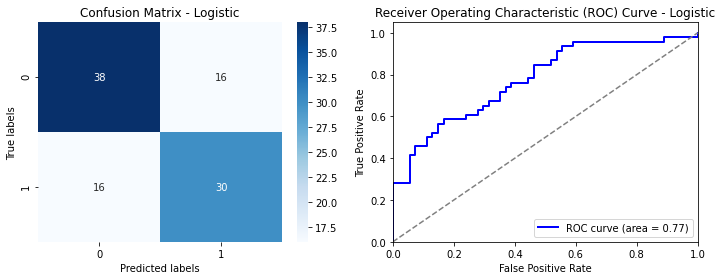

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

# CSV 파일 로드
df = pd.read_csv("client_scores_epoch5.csv", header=None)

# 열 이름 변경
new_columns = [f"Rank_{i+1}" for i in range(len(df.columns))]
df.columns = new_columns

# 데이터와 라벨 분리
X = df  # 첫 번째 열은 라벨이 아니므로 제외
y = [1] * 250 + [0] * 250  # 라벨 할당

# 데이터를 학습용과 테스트용으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 초기화 및 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# SVM 모델 초기화 및 학습
svmreg = SVC()
svmreg.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test)
svm_pred = svmreg.predict(X_test)

# 정확도 출력
print("Logistic Accuracy:", accuracy_score(y_test, y_pred))
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))

# Confusion Matrix 계산
logistic_cm = confusion_matrix(y_test, y_pred)
svm_cm = confusion_matrix(y_test, svm_pred)

# Confusion Matrix 시각화 (Logistic Regression)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(logistic_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Logistic')

# AUROC를 계산하고 시각화
y_pred_proba = model.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_proba)
print("AUROC - Logistic:", auroc)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic')
plt.legend(loc="lower right")

# 결과를 파일로 저장
logistic_predictions = np.array(y_pred)
true_labels = np.array(y_test)
np.save("logistic_predictions.npy", logistic_predictions)
np.save("true_labels.npy", true_labels)

plt.tight_layout()
plt.show()


In [31]:
X.shape

(500, 5)

[[-5.26070608e-04 -4.04867359e-05  0.00000000e+00  6.96918635e-05
   7.10917037e-05]
 [-3.65110690e-02 -2.17233020e-02 -2.14779529e-02 -2.05076073e-02
  -2.03553848e-02]
 [-9.94220609e-03 -6.48276689e-03 -6.47673398e-03 -6.30848709e-03
  -6.30641785e-03]
 ...
 [-7.88783638e-02 -5.03078187e-02 -4.98850010e-02 -4.94956607e-02
  -4.80239362e-02]
 [-7.63828342e-03 -7.00919689e-03 -6.17601627e-03 -6.11348449e-03
  -5.77557173e-03]
 [-6.94824905e-02 -4.05499602e-02 -3.88855219e-02 -3.79706695e-02
  -3.67463374e-02]]


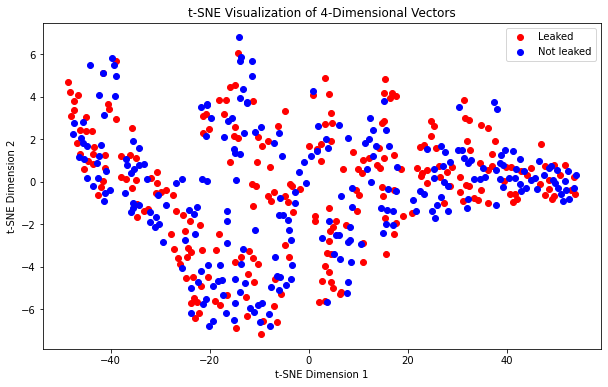

In [83]:
# t_SNE
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 유클리드 거리 계산 함수 정의
def calculate_euclidean_distances(client_file, dictionary_file):
    # 변환된 파일을 읽어옵니다.
    client_data = pd.read_csv(client_file)
    dictionary_data = pd.read_csv(dictionary_file)
    
    # 데이터 포인트 간의 유클리드 거리를 계산합니다.
    distances = euclidean_distances(client_data.values, dictionary_data.values)
    
    # top@1 score를 뺀 후 4차원 벡터화
    top1_scores = distances[:, 0]
    top5_scores = np.sort(distances, axis=1)[:, :5]
    top5_minus_top1 = top5_scores - top1_scores[:, np.newaxis]
    
    return top5_minus_top1

# 변환된 파일 경로
dictionary_file = "Dictionary_smashed_data_layer2.csv"

# t-SNE를 위한 4차원 벡터 계산
vectors_list = []
for i in range(2, 3):
    client_file = f'Client_smashed_data_epoch{i}.csv'
    vectors = calculate_euclidean_distances(client_file, dictionary_file)
    print(vectors)
    vectors_list.append(vectors)

# 리스트를 배열로 변환
vectors_array = np.concatenate(vectors_list, axis=0)

# t-SNE를 적용하여 2차원으로 축소
tsne = TSNE(n_components=2, random_state=42)
transformed_vectors = tsne.fit_transform(vectors_array)

# 첫 번째부터 250번째 벡터까지 빨간색, 이후는 파란색으로 점을 찍어 시각화
plt.figure(figsize=(10, 6))
plt.scatter(transformed_vectors[:250, 0], transformed_vectors[:250, 1], color='red', label='Leaked')
plt.scatter(transformed_vectors[250:, 0], transformed_vectors[250:, 1], color='blue', label='Not leaked')
plt.title('t-SNE Visualization of 4-Dimensional Vectors')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


In [7]:
from transformers import BertModel

def main():
    # BertModel 인스턴스 생성
    bert_model = BertModel.from_pretrained("bert-base-uncased")
    
    # 7번째 레이어에 접근
    seventh_layer = bert_model.encoder.layer[-4]

    # 7번째 레이어 출력
    print(seventh_layer)

if __name__ == "__main__":
    main()

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [46]:
import pandas as pd
import numpy as np

# 파일 순회
for i in range(13):  # 0부터 12까지의 파일을 처리
    file_name = f'Client_smashed_data_layer{i}.csv'
    try:
        # CSV 파일 읽기
        df = pd.read_csv(file_name, header=None, skiprows=1)
        
        # 벡터 데이터 추출
        vector_data = df.values.flatten()
        
        # 모양(shape) 출력
        print(f'Shape of data in {file_name}: {vector_data.shape}')
        
        # L2norm 계산
        l2_norm = np.linalg.norm(vector_data, ord=2)
        
        # L2norm 출력
        print(f'L2norm of data in {file_name}: {l2_norm}\n')
        
    except FileNotFoundError:
        print(f'File {file_name} not found.\n')

Shape of data in Client_smashed_data_layer0.csv: (768,)
L2norm of data in Client_smashed_data_layer0.csv: 14.491442262257587

Shape of data in Client_smashed_data_layer1.csv: (768,)
L2norm of data in Client_smashed_data_layer1.csv: 11.842984372695128

Shape of data in Client_smashed_data_layer2.csv: (768,)
L2norm of data in Client_smashed_data_layer2.csv: 12.648394121654427

Shape of data in Client_smashed_data_layer3.csv: (768,)
L2norm of data in Client_smashed_data_layer3.csv: 12.65642610967556

Shape of data in Client_smashed_data_layer4.csv: (768,)
L2norm of data in Client_smashed_data_layer4.csv: 17.455627849734213

Shape of data in Client_smashed_data_layer5.csv: (768,)
L2norm of data in Client_smashed_data_layer5.csv: 19.394996531031193

Shape of data in Client_smashed_data_layer6.csv: (768,)
L2norm of data in Client_smashed_data_layer6.csv: 20.697082216115405

Shape of data in Client_smashed_data_layer7.csv: (768,)
L2norm of data in Client_smashed_data_layer7.csv: 20.5756489626